In [66]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys, os
import pickle

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from CosineTuning import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 2
max_ndays      = 1e99
participant    = 'T5'


FILE_DIR       = os.path.join(DATA_DIR, participant, 'raw_data/')
filelist       = glob.glob(os.path.join(FILE_DIR, 'historical/*'))

filelist.extend(glob.glob(os.path.join(FILE_DIR, 'new/*')))
block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First let's generate some cosine tuning curves from two separate sessions:

In [5]:
from session_utils import getFields


figSize(7, 15)
np.random.seed(41)


# general settings: 
fields = ['TX', 'cursorPos', 'targetPos']
task   = None
blocks = None

# Tuning curve plotting:
n_bins     = 15
n_iters    = 1000


cos_data = dict()
cos_data['tuning']     = np.zeros((2, 192, 3))  # r_0 (baseline), alpha (modulation), theta (preferred dir)
cos_data['curves_old'] = list()
cos_data['curves_new'] = list()
cos_data['binned_rates_old'] = list()
cos_data['binned_rates_new'] = list()

for i, f in enumerate([files[i] for i in range(2)]):
    dat     = DataStruct(f, causal_filter = 2)
    results = getFields(dat, fields, task = task, blocks = blocks)
    
    for key, value in results.items():
        results[key] = np.concatenate(value, dtype = object)
        
    results['displacement'] = [x-y for x, y in zip(results['targetPos'], results['cursorPos'])]
    FR_estimates            = np.zeros((n_bins, dat.n_channels, len(results['displacement'])))
    
    for j, (trl_neural, trl_displacement) in enumerate(zip(results['TX'], results['displacement'])):
        binned, labels  = fit_BinnedAngles(trl_displacement, n_bins)
        for k in range(n_bins):       
            angle_idxs            = np.where(binned == k+1)[0]
            if len(angle_idxs) > 10:
                FR_estimates[k, :, j] = trl_neural[angle_idxs, :].mean(axis = 0)
            else:
                FR_estimates[k, :, j] = np.nan
        
    # get bootstrapped CIs for each bin:
    for k in range(n_bins):
        bs = scipy.stats.bootstrap((FR_estimates[k, :, :],), np.nanmean, axis = 1, confidence_level = 0.95,
                                   n_resamples = n_iters, method = 'percentile')

        FR_estimates[k, :, 1] = bs.confidence_interval.low
        FR_estimates[k, :, 2] = bs.confidence_interval.high

    for key, value in results.items():
        results[key] = np.concatenate(value)

    vel_angle = getAngles(results['displacement'], returnFullAngle = True)
    key       = 'old' if i == 1 else 'new'
    cos_data['binned_rates_' + key] = FR_estimates 
    
    for j in range(192):
        cos                  = CosineTuningModel().fit(vel_angle, results['TX'][:, j])
        preds_cos            = cos.predict(labels)
        cos_data['tuning'][i, j, :] = (cos.r_0, cos.alpha, cos.theta)
        cos_data['curves_' + key].append(preds_cos)
        

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


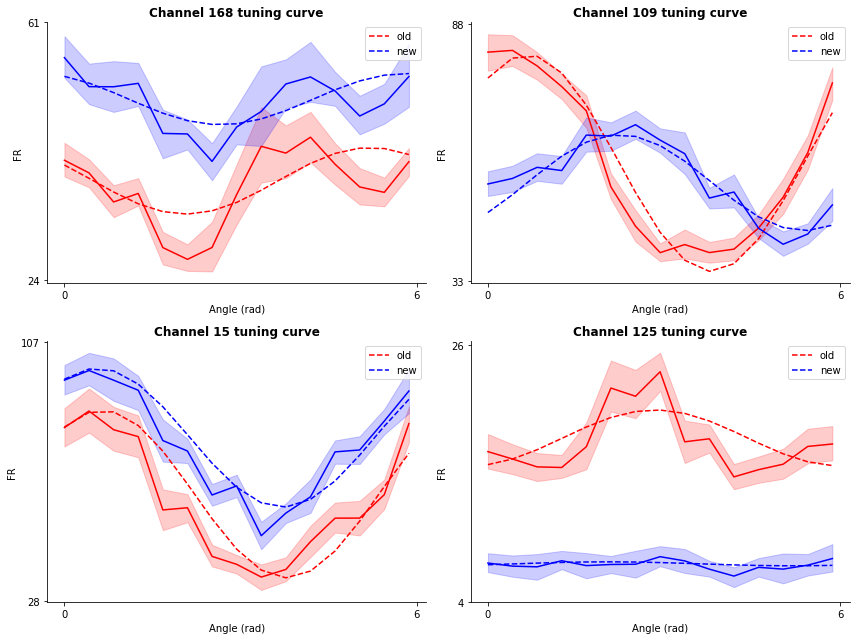

In [7]:
# plot results 

figSize(9, 12)

plt.figure()
for i, ch in enumerate([168, 109, 15, 125]):
    plt.subplot(2, 2, i + 1)

    for key, color in zip(['old', 'new'], ['r', 'b']):

        ch_preds  = cos_data['curves_' + key][ch].T
        ch_actual = cos_data['binned_rates_' + key][:, ch, :]
        
        plt.fill_between(labels, ch_actual[:, 1], ch_actual[:, 2], color=color, alpha=0.2)
        plt.plot(labels, ch_preds, c = color, linestyle = '--', label = key)        
        plt.plot(labels, np.nanmean(ch_actual[:], axis = 1), c = color)
    
    plt.legend()
    plt.title('Channel ' + str(ch) + ' tuning curve', fontweight = 'bold')
    
    plt.xlabel('Angle (rad)')
    plt.ylabel('FR')
    
    plt.xticks([0, 6])
    plt.yticks(np.round(plt.ylim(), 0))
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(FIG_DIR + 'T5_cosine_drift', format = 'pdf')
plt.show()

Now let's look at some more systematic measures of change across time:

In [47]:
def plotAngleDifferences(x, angles, colors, labels = None, alpha = None):
    '''Plot angular differences across time. Inputs are:
    
        x (1D float array)    - nSamples of x-axis values 
        angles (2D float)     - nSamples x nClasses of angles 
        colors (1D str array) - nClasses of colors 
        labels (1D str array) - nClasses of labels
        
    '''
    
    nClasses = angles.shape[1]
    
    if labels == None:
        labels = [None] * nClasses
    
    for i in range(nClasses):
        y = angles[:, i]
        plt.scatter(x, y, alpha = alpha, color = colors[i], label = labels[i])

    plt.ylabel('Tuning similarity (Cos $\theta$)')
    plt.axhline(0, c = 'k', linestyle = '--')
    plt.ylim([-1, 1])
    plt.legend()

In [153]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings


def search_regularization(reg_opts, x_train, y_train):
    '''Search L2 regularization strengths. Inputs are:
    
        reg_opts (list of float) - regularization values to sweep
        x_train (2D float)       - time x channels of neural activity
        y_train (2D float)       - time x 2 of intention vectors to predict'''
    
    tuned_params = {'alpha' : reg_opts}
    clf          = GridSearchCV(Ridge(), tuned_params).fit(x_train, y_train)
    
    return clf.best_estimator_


def train_decoders(train_x, train_y, test_x, test_y, cfg):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        decoder      = search_regularization(cfg['reg_opts'], train_x, train_y)
        test_decoder = search_regularization(cfg['reg_opts'], test_x, test_y)
        score        = decoder.score(test_x, test_y)
    
    return decoder, test_decoder, score



def processSingleSession(file, cfg):
    
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True) 
    session_dict['decoder_means'] = session_dat['test_TX'][-1].mean(axis = 0)
    
    train_y = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y  = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)

    # ===== train decoders ======
    
    #if no existing decoder folder is provided, train from scratch
    if cfg['decoder_folder'] is None:
        decoder, test_decoder, score = train_decoders(train_x, train_y, test_x, test_y, cfg)
          
    # decoder folder passed
    else:
        save_fname = os.path.join(cfg['decoder_folder'], session.date + '_linear_decoder.npy')
        
        # if decoder file already exists
        if False: #os.path.isfile(save_fname):
            lm_dat = pickle.load(open(save_fname, 'rb'))
            decoder = lm_dat['decoder']
            test_decoder = lm_dat['test_decoder']
            score   = lm_dat['R2']
        
        # if it doesnt exist, train decoder then save to folder
        else: 
            decoder, test_decoder, score = train_decoders(train_x, train_y, test_x, test_y, cfg)
            save_fname = os.path.join(cfg['decoder_folder'], f'{session.date}_linear_decoder.npy')
            if not os.path.isfile(save_fname):
                with open(save_fname, 'wb') as f:
                    pickle.dump({'decoder' : decoder, 
                                 'test_decoder' : test_decoder,
                                 'R2' : score, 
                                 'date' : session.date}, 
                                f)
                    
    # ==== train cosine tuning models =====
    encoder      = fitEncodingMatrix(train_y, train_x, fitMean = False)[0]
    test_encoder = fitEncodingMatrix(test_y, test_x, fitMean = False)[0]

    # measure within-session bias changes:
    session_dict['normalized_bias_index']         = estimateNormalizedBias(decoder, test_x, test_y, threshold = cfg['threshold'])
    session_dict['normalized_bias_index_control'] = estimateNormalizedBias(decoder, train_x, train_y, threshold = cfg['threshold'])

    # measure within-session PD changes:
    encoder_angles, encoder_overall = estimateSubspaceDrift(encoder[1:, :], test_encoder[1:, :])
    decoder_angles, decoder_overall = estimateSubspaceDrift(decoder.coef_, test_decoder.coef_)

    session_dict['encoder_angles'] = encoder_angles
    session_dict['decoder_angles'] = decoder_angles
    session_dict['combined_decoder_angle'] = decoder_overall

    session_dict['dates']    = deepcopy(session.date)
    session_dict['scores']   = score
    session_dict['encoders'] = encoder
    session_dict['decoders'] = decoder
    
    return session_dict

In [ ]:
# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2
cfg['reg_opts']     = [1e1, 1e3, 1e5, 1e7, 1e9]
cfg['threshold']    = 300
cfg['decoder_folder'] = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T5/session_decoders/'

# Results here may look a bit different due to random seed settings for your own data
# after generating the first time, results will be cached and can be accessed more readily
# --------------------------------------------------
uniqueFiles  = np.unique(np.concatenate(pairs))
dict_list    = Parallel(n_jobs=-1, verbose = 5)(delayed(processSingleSession)(file, cfg) for file in uniqueFiles)
session_dict = dict()

for key in dict_list[0].keys():
    session_dict[key] = list()
    for d in dict_list:
        session_dict[key].append(d[key])
        
        
# now plot bias index and PD shift angle on test set within-session:
import pandas as pd 

figSize(5, 10)

plt.subplot(1, 2, 1)
plt.scatter(session_dict['normalized_bias_index'], session_dict['scores'])
plt.xlabel('Bias index')
plt.ylabel('R^2')

plt.subplot(1, 2, 2)
plt.scatter(session_dict['combined_decoder_angle'], session_dict['scores'])
plt.xlabel('Decoder angle (radians)')
plt.ylabel('R^2')

plt.suptitle('Bias and PD shifts within-session (holdout data)')
plt.show()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  29 out of  73 | elapsed:  4.0min remaining:  6.0min


In [ ]:
import matplotlib as mpl 
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.plasma
m    = cm.ScalarMappable(norm=norm, cmap= cmap)


print('-------- Within-session ---------')

# drop massive outlier
outlier_idx = 33
control_bias = np.asarray(session_dict['normalized_bias_index_control'])
test_bias = np.asarray(session_dict['normalized_bias_index'])

control_bias = np.delete(control_bias, outlier_idx)
test_bias = np.delete(test_bias, outlier_idx)

mean = np.mean(control_bias)
SD   = np.std(control_bias)
print('Normalized bias index (control): {:.3f} +- {:.3f}'.format(mean, SD))

mean = np.mean(test_bias)
SD   = np.std(test_bias)
print('Normalized bias index (test): {:.3f} +- {:.3f}'.format(mean, SD))

bias_diffs = test_bias - control_bias
print('Wilcoxon test of differences: p = {:.3E}'.format(scipy.stats.wilcoxon(bias_diffs)[1]))


figSize(5, 5)
colors = m.to_rgba(np.delete(np.asarray(session_dict['scores']), outlier_idx))

plt.scatter(control_bias, test_bias, c = colors, alpha = 0.5)
plt.xlabel('Training bias')
plt.ylabel('Test bias')
plt.ylim([0,1.2])
plt.xlim([0,1.2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(FIG_DIR + 'SNR/T5_bias_withinsession_comparison', format = 'pdf')
plt.show()

Now look at across-session drift:

In [ ]:
def generatePairData(A_file, B_file, cfg):
    
    dict_fields = ['reference date', 'new date', 'days apart', 'encoder angles', 'decoder angles', 'combined decoder angle', 
               'full recal score', 'meanrecal score', 'norecal score', 'normalized_bias_index']
    scores_dict = dict()
    
    for key in dict_fields:
        scores_dict[key] = list()
    
    # metadata 
    A_date   = A_file.split('t5.')[1].split('.mat')[0]
    B_date   = B_file.split('t5.')[1].split('.mat')[0]

    scores_dict['reference date'].append(A_date)
    scores_dict['new date'].append(B_date)
    scores_dict['days apart'].append(daysBetween(A_date, B_date))

    A_ind  = np.where(np.in1d(session_dict['dates'], A_date))[0][0]
    B_ind  = np.where(np.in1d(session_dict['dates'], B_date))[0][0]

    # angular drift metrics
    
    encoder_angles, encoder_overall = estimateSubspaceDrift(session_dict['encoders'][A_ind][1:, :], 
                                                            session_dict['encoders'][B_ind][1:, :])
    
    decoder_angles, decoder_overall = estimateSubspaceDrift(session_dict['decoders'][A_ind].coef_, 
                                                            session_dict['decoders'][B_ind].coef_)
    
    
    scores_dict['encoder angles'].append(encoder_angles)
    scores_dict['decoder angles'].append(decoder_angles)
    scores_dict['combined decoder angle'].append(decoder_overall)


    # functional metrics - offline R^2  
    scores_dict['full recal score'].append(session_dict['scores'][B_ind])

    session = DataStruct(B_file, causal_filter = cfg['sigma'], alignScreens = True)

    # obtain features and cursorError targets:
    fields          = ['TX', 'cursorPos', 'targetPos']
    session_dat     = getTrainTest(session, fields = fields, train_size = cfg['train_size'], task = cfg['task'], returnFlattened = True)    
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    # 
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], 
                                    method = 'blockwise', concatenate = True)
    meanrecal_score = session_dict['decoders'][A_ind].score(test_x, test_y)
    scores_dict['meanrecal score'].append(meanrecal_score)  

    # 
    #print(session_dict['decoder_means'][A_ind])
    test_x  = np.concatenate(session_dat['test_TX']) - session_dict['decoder_means'][A_ind][None, :]

    norecal_score = session_dict['decoders'][A_ind].score(test_x, test_y) 
    scores_dict['norecal score'].append(norecal_score)

    bias_index  = estimateNormalizedBias(session_dict['decoders'][A_ind], test_x, test_y, threshold = 300)
    scores_dict['normalized_bias_index'].append(bias_index)
    
    return scores_dict


In [ ]:
from joblib import Parallel, delayed
import pandas as pd


dict_list   = Parallel(n_jobs=-1, verbose = 1)(delayed(generatePairData)(*arg, cfg) for arg in pairs)
scores_dict = pd.DataFrame(dict_list).to_dict()

for key, value in scores_dict.items():
    scores_dict[key] = np.concatenate(list(value.values()))

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm

# define colormap based on R2 value
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.plasma
m    = cm.ScalarMappable(norm=norm, cmap= cmap)

# optionally subselect points 
#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

figSize(10, 20)

plt.subplot(2, 2, 1)
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['full recal score'])
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['meanrecal score'])
plt.legend(['Mean recal', 'Full recal'])
plt.title('Mean recalibration versus full recalibration')
plt.xlabel('Days (log10)')
plt.ylabel('R^2 score')

plt.subplot(2, 2, 2)
y = np.asarray(scores_dict['meanrecal score']) / np.asarray(scores_dict['full recal score'])

sns.scatterplot(x = np.log10(scores_dict['days apart']), y = y)
plt.ylim([-1.05, 1.05])
plt.title('Relative mean recalibration performance (normalized by within-day performance)')
plt.xlabel('Days (log10)')
plt.ylabel('Relative R^2')
ax = plt.gca()
ax.tick_params(direction = 'in')

# PD shift across time
plt.subplot(2, 2, 3)

alpha     = 0.5

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y         = np.cos(np.vstack(scores_dict['combined decoder angle'])[subselect, :][sort_idx])
colors = [m.to_rgba(np.asarray(scores_dict['meanrecal score'])[subselect][sort_idx])]

plotAngleDifferences(x, y, colors, None, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')
plt.colorbar(m)
ax = plt.gca()
ax.tick_params(direction = 'in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# within-session 
y_session = np.cos(np.asarray(session_dict['combined_decoder_angle']))
#y_session = y_session[y_session > 0]
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
colors    = m.to_rgba(session_dict['scores'])

plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')
plt.ylim([-1.05, 1.05])

# ======== Bias across time ==========
plt.subplot(2, 2, 4)
y = np.asarray(scores_dict['normalized_bias_index'])
x = np.asarray(scores_dict['days apart'])
x = np.log10(x)
colors = m.to_rgba(np.asarray(scores_dict['norecal score']))

plt.scatter(x[y < 10], y[y < 10], c = colors[y < 10], alpha = alpha )

# within-session: test
colors    = m.to_rgba(session_dict['scores'])

y_session = np.asarray(session_dict['normalized_bias_index'])
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')

# within-session: train
y_session = np.asarray(session_dict['normalized_bias_index_control'])
x_session = np.random.normal(-1.5, 0.05, y_session.shape)
plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session (control)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.tick_params(direction = 'in')

plt.ylim([-0.001, 10])
plt.xlabel('Number of days apart (log difference)')
plt.ylabel('Normalized bias index')
plt.legend()
plt.title('Bias across time', fontweight = 'bold')
plt.colorbar(m)

plt.tight_layout()
plt.savefig(FIG_DIR + 'SNR/T5_EncDec_Drift.pdf', format = 'pdf')
plt.show()

In [ ]:
daterange = [7, 14]


print('Within-day:')
print('R2 values:', np.median(session_dict['scores']))
print('Angle values:', np.median(session_dict['decoder_angles']) * 180/ np.pi)
print('R2 values:',  np.median(session_dict['scores']))

idxs   = np.logical_and(scores_dict['days apart'] >= daterange[0], scores_dict['days apart'] <= daterange[1])
biases = scores_dict['normalized_bias_index'][idxs]
angles = scores_dict['combined decoder angle'][idxs]
R2s    = scores_dict['meanrecal score'][idxs]
print('\nBias index values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(biases))
print('Angle values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(angles) * 180 / np.pi)
print('R2 values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(R2s))

In [ ]:
figSize(10, 10)

timelen           = np.arange(10000, 11000)
example_bias_id   = 1550
example_tuning_id = 97

for i, example_id in enumerate([example_bias_id, example_tuning_id]):
    ref_date = scores_dict['reference date'][example_id]
    new_date = scores_dict['new date'][example_id]
    ref_file = [f for f in files if ref_date in f][0]
    new_file = [f for f in files if new_date in f][0]
    A_ind    = np.where(np.in1d(session_dict['dates'], ref_date))[0][0]
    B_ind    = np.where(np.in1d(session_dict['dates'], new_date))[0][0]
    
    new_session = DataStruct(new_file, causal_filter = cfg['sigma'], alignScreens = True)

    # obtain features and cursorError targets:
    fields          = ['TX', 'cursorPos', 'targetPos']
    session_dat     = getTrainTest(new_session, fields = fields, train_size = cfg['train_size'], task = cfg['task'], returnFlattened = True)    
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    # 
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)
    meanrecal_preds = session_dict['decoders'][A_ind].predict(test_x)
    fullrecal_preds = session_dict['decoders'][B_ind].predict(test_x)
 
    test_x        = np.concatenate(session_dat['test_TX']) - session_dict['decoder_means'][A_ind][None, :]
    norecal_preds = session_dict['decoders'][A_ind].predict(test_x)
        
    norecal_score   = np.round(scores_dict['norecal score'][example_id], 3)
    meanrecal_score = np.round(scores_dict['meanrecal score'][example_id], 3)
    fullrecal_score = np.round(scores_dict['full recal score'][example_id], 3)

    plt.subplot(2, 1, i + 1)
    for j in range(2):
        plt.plot((timelen - timelen[0]) / 50, test_y[timelen, j] + (j * 800), color = 'k')
        
        if i == 0:
            plt.plot((timelen - timelen[0]) / 50, meanrecal_preds[timelen, j] + (j * 800), linestyle = '-', color = 'blue', alpha = 0.7)
            plt.plot((timelen - timelen[0]) / 50, norecal_preds[timelen, :][:, j] + (j * 800), linestyle = '-', color = 'red', alpha = 0.7)
            plt.legend(['True', 'Means adjusted', 'No adjustment'])
            plt.title(f'Norecal = {norecal_score}, meanrecal = {meanrecal_score}')

        else:
            plt.plot((timelen - timelen[0]) / 50, fullrecal_preds[timelen, j] + (j * 800), linestyle = '-', color = 'blue', alpha = 0.7)
            plt.plot((timelen - timelen[0]) / 50, meanrecal_preds[timelen, :][:, j] + (j * 800), linestyle = '-', color = 'red', alpha = 0.7)
            plt.legend(['True', 'New (means adjusted)', 'Reference (means adjusted)'])
            plt.title(f'meanrecal = {meanrecal_score}, fullrecall = {fullrecal_score}')
        
        plt.xlabel('Time (sec)')
        plt.ylabel('Cursor Error (a.u.)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
fname = os.path.join(FIG_DIR, 'SNR/example_nonstationarities_decoding')
plt.savefig(fname, format = 'pdf')

plt.show()

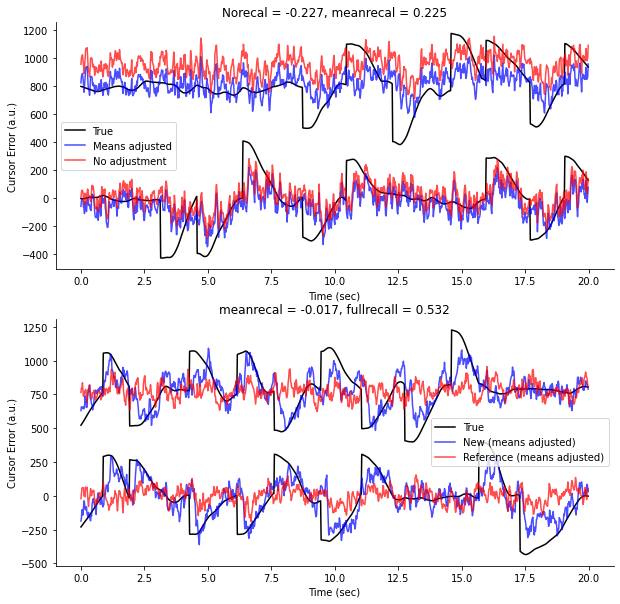

In [102]:
figSize(10, 10)

timelen           = np.arange(10000, 11000)
example_bias_id   = 1550
example_tuning_id = 97

for i, example_id in enumerate([example_bias_id, example_tuning_id]):
    ref_date = scores_dict['reference date'][example_id]
    new_date = scores_dict['new date'][example_id]
    ref_file = [f for f in files if ref_date in f][0]
    new_file = [f for f in files if new_date in f][0]
    A_ind    = np.where(np.in1d(session_dict['dates'], ref_date))[0][0]
    B_ind    = np.where(np.in1d(session_dict['dates'], new_date))[0][0]
    
    new_session = DataStruct(new_file, causal_filter = cfg['sigma'], alignScreens = True)

    # obtain features and cursorError targets:
    fields          = ['TX', 'cursorPos', 'targetPos']
    session_dat     = getTrainTest(new_session, fields = fields, train_size = cfg['train_size'], task = cfg['task'], returnFlattened = True)    
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    # 
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)
    meanrecal_preds = session_dict['decoders'][A_ind].predict(test_x)
    fullrecal_preds = session_dict['decoders'][B_ind].predict(test_x)
 
    test_x        = np.concatenate(session_dat['test_TX']) - session_dict['decoder_means'][A_ind][None, :]
    norecal_preds = session_dict['decoders'][A_ind].predict(test_x)
        
    norecal_score   = np.round(scores_dict['norecal score'][example_id], 3)
    meanrecal_score = np.round(scores_dict['meanrecal score'][example_id], 3)
    fullrecal_score = np.round(scores_dict['full recal score'][example_id], 3)

    plt.subplot(2, 1, i + 1)
    for j in range(2):
        plt.plot((timelen - timelen[0]) / 50, test_y[timelen, j] + (j * 800), color = 'k')
        
        if i == 0:
            plt.plot((timelen - timelen[0]) / 50, meanrecal_preds[timelen, j] + (j * 800), linestyle = '-', color = 'blue', alpha = 0.7)
            plt.plot((timelen - timelen[0]) / 50, norecal_preds[timelen, :][:, j] + (j * 800), linestyle = '-', color = 'red', alpha = 0.7)
            plt.legend(['True', 'Means adjusted', 'No adjustment'])
            plt.title(f'Norecal = {norecal_score}, meanrecal = {meanrecal_score}')

        else:
            plt.plot((timelen - timelen[0]) / 50, fullrecal_preds[timelen, j] + (j * 800), linestyle = '-', color = 'blue', alpha = 0.7)
            plt.plot((timelen - timelen[0]) / 50, meanrecal_preds[timelen, :][:, j] + (j * 800), linestyle = '-', color = 'red', alpha = 0.7)
            plt.legend(['True', 'New (means adjusted)', 'Reference (means adjusted)'])
            plt.title(f'meanrecal = {meanrecal_score}, fullrecall = {fullrecal_score}')
        
        plt.xlabel('Time (sec)')
        plt.ylabel('Cursor Error (a.u.)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
fname = os.path.join(FIG_DIR, 'SNR/example_nonstationarities_decoding')
plt.savefig(fname, format = 'pdf')

plt.show()

Changes within two weeks:

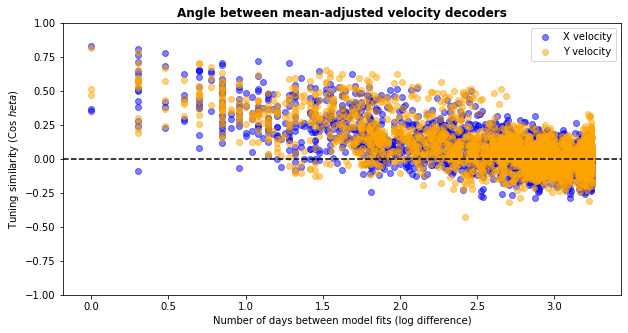

In [99]:
figSize(5, 10)

colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y         = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')

plt.show()

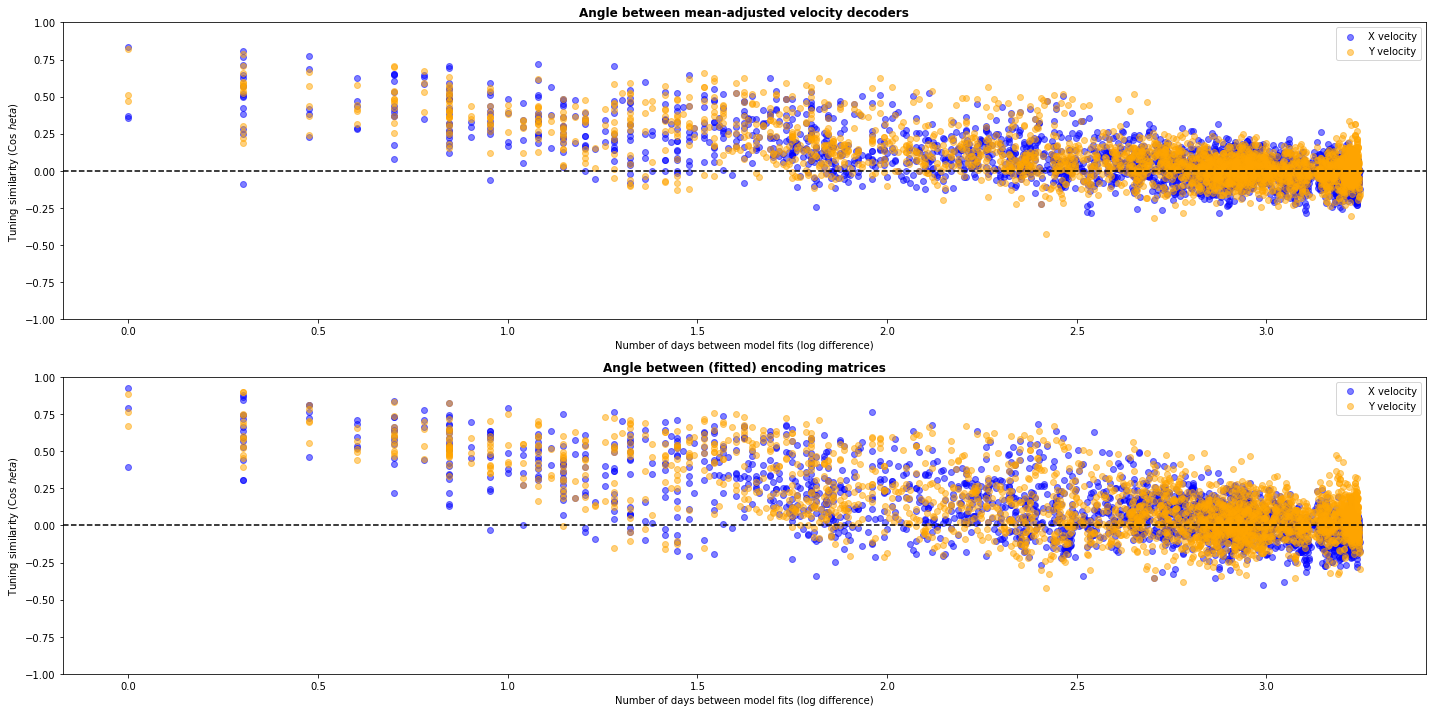

In [100]:
from scipy.signal import savgol_filter

figSize(10, 20)

n_iters   = 1000
colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])

# Decoders
plt.subplot(2, 1, 1)

y = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')


# Encodings:
plt.subplot(2, 1, 2)

y = np.cos(np.vstack(scores_dict['encoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between (fitted) encoding matrices', fontweight = 'bold')


plt.tight_layout()
#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift', format = 'pdf')
plt.show()


### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

Base alpha =  0.9127546639283498
Base alpha =  0.9250748939988905


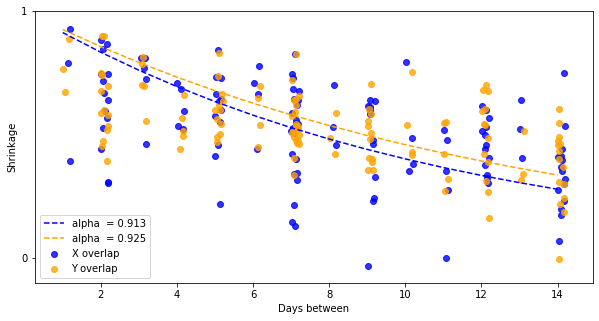

In [101]:
def fitDecayModel(x, y):
    
    pos_mask = y > 0
        
    x_filt = x[pos_mask][:, np.newaxis]
    y_filt = y[pos_mask][:, np.newaxis]
    
    mult  = np.linalg.lstsq(x_filt, np.log(y_filt), rcond = None)[0][0][0]
    alpha = np.exp(mult)
    
    return alpha

figSize(5, 10)
window = 14 # look at sessions up to two weeks apart
colors = ['b', 'orange']
labels = ['X overlap', 'Y overlap']


withinWindow      = np.where(scores_dict['days apart'] <= window)[0]
withinDiffs       = scores_dict['days apart'][withinWindow]

for i in range(2):
    withinShrinkages  = np.cos(scores_dict['encoder angles'][withinWindow, i])
    alpha  = fitDecayModel(withinDiffs, withinShrinkages) 
    print('Base alpha = ', alpha)
    
    x = np.arange(1, max(withinDiffs) + 1)
    y = alpha**x
    plt.scatter(withinDiffs + (0.2 * np.random.rand(*withinDiffs.shape)), withinShrinkages, alpha = 0.8, color = colors[i], label = labels[i])
    plt.plot(x, y, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))

plt.ylim([-0.1, 1])
plt.yticks([0, 1])
plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()
#plt.savefig(fig_path + 'SNR/T5_Enc_drift_twoweeks', format = 'pdf')
plt.show()